# Analysis of venues categories in the neighborhoods of Madrid - Week 2

#### Applied Data Science Capstone by IBM/Coursera

---
---
---
## Table of contents
* 1. Introduction
    * 1.1. Business problem
    * 1.2. Stakeholders
* 2. Data
    * 2.1. Madrid boroughs and neighborhoods data
    * 2.2. Foursquare data
* 3. Methodology
* 4. Analysis
    * 4.1. First approach
    * 4.2. Second approach
* 5. Results
* 6. Conclusion

---
---
---
## 1. Introduction

### 1.1. Business problem

How are venues distributed among the neighborhoods in Madrid? Where are the neighborhoods in which a certain venue category is specially usual? Which is the most common venue category in each neighborhood? Is there any "outlier" neighborhood in Madrid? Could this information be leveraged in any way? All these questions define the business problem around which this data science project revolves.

---
---
---
### 1.2. Stakeholders

Madrid is a city brimming with culture, leisure, catering and hostelry, and so it attracts many entrepreneurs and investors from these fields. These are the stakeholders in this business problem. To boost the chances of success of their enterprises and investments, many of them rely on market researches which try to answer questions such as: 

* If a business of a specific type is to be put into operation, where are the neighborhoods in Madrid which should be targeted? How are they distributed in the city? In the suburbs, in the down town, in the old city?

* If a the stakeholder plans to put a business of any type into operation in a specific neighborhood of Madrid, what business types should they consider? Is this neighborhood saturated with a particular type of business? Does this neighborhood lack any type of business? What is the market niche?

* Is there any "special" neighborhood in Madrid regarding its venues? Does it offer any special market opportunity to the entrepreneurs and investors?

* Finally, considering that venues open, close or simply change overnight, would it be possible to have this information dynamically updated? 

This data science project aims to answer all of these questions for the stakeholders.

---
---
---
## 2. Data

### 2.1. Madrid boroughs and neighborhoods data

They are freely available on [Madrid City Council Open Data website](https://datos.madrid.es/egob/catalogo/200078-10-distritos-barrios.zip). They come in the form of geospatial vector data files of Madrid boroughs and neighborhoods. Once downloaded, these files are loaded in QGIS, a free and open-source cross-platform desktop geographic information system, in order to be processed. See Illustration 1 below.

![Madrid boroughs and neighborhoods](https://raw.githubusercontent.com/d-sanchez-valenciano/Applied-Data-Science-Capstone/master/Madrid%20neighborhoods.png "Illustration 1. Madrid boroughs and neighborhoods geospatial vector data files loaded in QGIS")

The files are processed leveraging QGIS functionalities so that the corresponding attributes table contains the following information for each neighborhood of Madrid. 
* Borough name.
* Neighborhood name.
* Area.
* Perimeter.
* X coordinate (ETRS89/UTM zone 30) of its centroid.
* Y coordinate (ETRS89/UTM zone 30) of its centroid.

See Illustration 2 below.

![Attributes table](https://github.com/d-sanchez-valenciano/Applied-Data-Science-Capstone/blob/master/Attributes%20table_R1.png?raw=true "Illustration 2. Madrid boroughs and neighborhoods geospatial vector data files final attributes table")

The final attributes table is exported as a comma separated values file (“madrid_neighborhoods.csv”). Then, it is loaded into the Watson Studio project as an asset. See Illustration 3 below. Finally, this file is read from this Jupyter Notebook using methods from project_lib and pandas libraries (see the corresponding cells below).

![CSV file](https://raw.githubusercontent.com/d-sanchez-valenciano/Applied-Data-Science-Capstone/master/CSV%20file_R1.png "Illustration 3. madrid_neighborhoods.csv file loaded into the Watson Studio project as an asset")

In [1]:
# The code was removed by Watson Studio for sharing.

---
---
#### Libraries

The relevant libraries are loaded

In [2]:
!pip install pyproj
from pyproj import Proj, transform

!conda install -c conda-forge folium=0.5.0 --yes
import folium

from pandas.io.json import json_normalize
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

import json
import math

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot
%matplotlib inline
import numpy
import pandas
import requests

Solving environment: done

# All requested packages already installed.



---
---
#### Data loading

In [3]:
madrid_neighborhoods_csv_file = project.get_file("Madrid_neighborhoods.csv")
madrid_neighborhoods_csv_file.seek(0) # Sets the file's current position at the offset

madrid_neighborhoods = pandas.read_csv(madrid_neighborhoods_csv_file, sep = ";", encoding = "latin_1", decimal = ",")

madrid_neighborhoods.head()

,Borough,Neighborhood,Area,Perimeter,X (ETRS89),Y (ETRS89)
0,Arganzuela,Acacias,1.073438e+06,3950.326928,439982.853563,4.472513e+06
1,Arganzuela,Atocha,7.356806e+05,4957.687404,442131.234603,4.472353e+06
2,Arganzuela,Chopera,5.677870e+05,3203.408600,440672.253579,4.471809e+06
3,Arganzuela,Delicias,1.054679e+06,4818.002750,441453.464123,4.472028e+06
4,Arganzuela,Imperial,9.676786e+05,4557.937959,439045.619911,4.473090e+06


In [4]:
print("\nThere are {} boroughs and {} neighborhoods in Madrid.\n".format(len(madrid_neighborhoods["Borough"].unique()), len(madrid_neighborhoods.index)))


There are 21 boroughs and 129 neighborhoods in Madrid.



---
---
#### Data pre processing

The shapes of the neighborhoods are approximated to circles, and the corresponding radius are calculated from the area. These radius will be used as the "radius" parameter when querying Foursquare so that the queries are in line with the size of the neighborhoods.

In [5]:
madrid_neighborhoods.insert(loc = 4, column = "Radius", value = madrid_neighborhoods["Area"])
madrid_neighborhoods["Radius"] = madrid_neighborhoods["Radius"].apply(lambda A: math.sqrt(A/math.pi)).astype("int")
madrid_neighborhoods.head()

,Borough,Neighborhood,Area,Perimeter,Radius,X (ETRS89),Y (ETRS89)
0,Arganzuela,Acacias,1.073438e+06,3950.326928,584,439982.853563,4.472513e+06
1,Arganzuela,Atocha,7.356806e+05,4957.687404,483,442131.234603,4.472353e+06
2,Arganzuela,Chopera,5.677870e+05,3203.408600,425,440672.253579,4.471809e+06
3,Arganzuela,Delicias,1.054679e+06,4818.002750,579,441453.464123,4.472028e+06
4,Arganzuela,Imperial,9.676786e+05,4557.937959,554,439045.619911,4.473090e+06


---
ETRS89/UTM Zone 30 coordinates are coverted into latitude and longitude using the pyproj library.

In [6]:
my_proj = Proj("+proj=utm +zone=30N, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
longitudes, latitudes = my_proj(madrid_neighborhoods["X (ETRS89)"].values, madrid_neighborhoods["Y (ETRS89)"].values, inverse = True)

madrid_neighborhoods["Latitude"] = pandas.Series(latitudes)
madrid_neighborhoods["Longitude"] = pandas.Series(longitudes)
madrid_neighborhoods.head()

,Borough,Neighborhood,Area,Perimeter,Radius,X (ETRS89),Y (ETRS89),Latitude,Longitude
0,Arganzuela,Acacias,1.073438e+06,3950.326928,584,439982.853563,4.472513e+06,40.401068,-3.707261
1,Arganzuela,Atocha,7.356806e+05,4957.687404,483,442131.234603,4.472353e+06,40.399774,-3.681931
2,Arganzuela,Chopera,5.677870e+05,3203.408600,425,440672.253579,4.471809e+06,40.394769,-3.699072
3,Arganzuela,Delicias,1.054679e+06,4818.002750,579,441453.464123,4.472028e+06,40.396799,-3.689887
4,Arganzuela,Imperial,9.676786e+05,4557.937959,554,439045.619911,4.473090e+06,40.406190,-3.718360


---
An initial map containing all Madrid neighborhoods is displayed.

In [7]:
madrid_map = folium.Map(location = [40.4165000, -3.7025600], zoom_start = 11)

for latitude, longitude, borough, neighborhood in zip(madrid_neighborhoods["Latitude"], madrid_neighborhoods["Longitude"], madrid_neighborhoods["Borough"], madrid_neighborhoods["Neighborhood"]):
    label = "{}, ({})".format(neighborhood, borough)
    label = folium.Popup(label)
    folium.CircleMarker(
        [latitude, longitude],
        radius  = 3,
        popup = label,
        color = "red",
        fill = True,
        fill_color = "red",
        fill_opacity = 0.25).add_to(madrid_map)  

madrid_map

---
---
---
### 2.2. Foursquare data

Foursquare API is leveraged to explore venues in each neighborhood in Madrid.

---
---
#### Credentials

Foursquare credentials and version are provided.

In [8]:
# The code was removed by Watson Studio for sharing.

---
---
#### Test neighborhood. Venues data loading

One test neighborhood is explored using Foursquare API on a trial basis.

In [9]:
test_neighborhood_name = madrid_neighborhoods.loc[0, "Neighborhood"]
test_neighborhood_latitude = madrid_neighborhoods.loc[0, "Latitude"]
test_neighborhood_longitude = madrid_neighborhoods.loc[0, "Longitude"]
test_neighborhood_radius = madrid_neighborhoods.loc[0, "Radius"]

print("\nThe test neighborhood to be explored is {}. Its latitude is {}. Its longitude is {}. Its radius is {}.\n".format(test_neighborhood_name, test_neighborhood_latitude, test_neighborhood_longitude, test_neighborhood_radius))


The test neighborhood to be explored is Acacias. Its latitude is 40.401067560640506. Its longitude is -3.707261008191076. Its radius is 584.



In [10]:
# URL
test_neighborhood_limit = 100
test_neighborhood_url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    client_id, 
    client_secret, 
    version, test_neighborhood_latitude, 
    test_neighborhood_longitude, 
    test_neighborhood_radius, 
    test_neighborhood_limit)


# Request
test_neighborhood_results = requests.get(test_neighborhood_url).json()


# Cleaning
test_neighborhood_venues = test_neighborhood_results["response"]["groups"][0]["items"]

test_neighborhood_venues = json_normalize(test_neighborhood_venues) # The semi-structured JSON data is normalized into a pandas dataframe

test_neighborhood_venues = test_neighborhood_venues[["venue.name", "venue.categories", "venue.location.lat", "venue.location.lng"]] # The relevant columns are extracted

def get_category(row): # Function to extract categories from venue.categories
    categories_list = row["venue.categories"]
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]["name"]

test_neighborhood_venues["venue.categories"] = test_neighborhood_venues.apply(get_category, axis = 1) # The categories from venue.categories are extracted

test_neighborhood_venues.rename({"venue.name": "Name", "venue.categories": "Category", "venue.location.lat": "Latitude", "venue.location.lng": "Longitude"}, axis = 1, inplace = True)

test_neighborhood_venues.head(25)

,Name,Category,Latitude,Longitude
0,La Gelateria di Angelo,Ice Cream Shop,40.397951,-3.707739
1,Parque de la Arganzuela,Park,40.398330,-3.708686
2,Restaurante Peruano Mis Tradiciones,Peruvian Restaurant,40.399816,-3.711022
3,sushi raku,Sushi Restaurant,40.404623,-3.708216
4,Le Crust Pizza Bar,Pizza Place,40.400922,-3.709890
5,AltaFit Puerta de Toledo,Gym / Fitness Center,40.405115,-3.707649
6,Toboganes Parque de la Arganzuela,Playground,40.398026,-3.710241
7,Sala Cuarta Pared,Indie Theater,40.402686,-3.702700
8,Café Ziryab,Pub,40.402244,-3.705137
9,Puente Monumental del Parque de la Arganzuela,Bridge,40.397671,-3.711777


---
---
#### All neighborhoods. Venues data loading

A function is defined to perform the previous process (neighborhood venues exploration) at once.

In [11]:
def get_nearby_venues(neighborhoods_names, neighborhoods_latitudes, neighborhoods_longitudes, neighborhoods_radius):
    
    venues_list = []
    for neighborhood_name, neighborhood_latitude, neighborhood_longitude, neighborhood_radius in zip(neighborhoods_names, neighborhoods_latitudes, neighborhoods_longitudes, neighborhoods_radius):
        
        # Info message
        print("Analyzing neighborhood {}...".format(neighborhood_name))
        
        
        # URL
        limit = 100
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            client_id, 
            client_secret, 
            version, 
            neighborhood_latitude, 
            neighborhood_longitude, 
            neighborhood_radius, 
            limit)
            
            
        # Request
        results = requests.get(url).json()
        
        
        # Neighborhood venues addition to venues list
        results = results["response"]["groups"][0]["items"]
        venues_list.append([
            (neighborhood_name, 
            neighborhood_latitude, 
            neighborhood_longitude, 
            venues["venue"]["name"],
            venues["venue"]["categories"][0]["name"], 
            venues["venue"]["location"]["lat"], 
            venues["venue"]["location"]["lng"])
            
            for venues in results
            ])

        
    nearby_venues = pandas.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        "Neighborhood", 
        "Neighborhood latitude", 
        "Neighborhood longitude", 
        "Venue name",
        "Venue category",
        "Venue latitude", 
        "Venue longitude"]
    
    
    return(nearby_venues)

---
The previously defined function is applied to all the neighborhoods of Madrid.

In [12]:
madrid_venues = get_nearby_venues(
    neighborhoods_names = madrid_neighborhoods["Neighborhood"],
    neighborhoods_latitudes = madrid_neighborhoods["Latitude"],
    neighborhoods_longitudes = madrid_neighborhoods["Longitude"],
    neighborhoods_radius = madrid_neighborhoods["Radius"]
)

madrid_venues.tail()

Analyzing neighborhood Acacias...
Analyzing neighborhood Atocha...
Analyzing neighborhood Chopera...
Analyzing neighborhood Delicias...
Analyzing neighborhood Imperial...
Analyzing neighborhood Legazpi...
Analyzing neighborhood Palos de Moguer...
Analyzing neighborhood Aeropuerto...
Analyzing neighborhood Alameda de Osuna...
Analyzing neighborhood Casco histórico de Barajas...
Analyzing neighborhood Corralejos...
Analyzing neighborhood Timón...
Analyzing neighborhood Abrantes...
Analyzing neighborhood Buenavista...
Analyzing neighborhood Comillas...
Analyzing neighborhood Opañel...
Analyzing neighborhood Puerta Bonita...
Analyzing neighborhood San Isidro...
Analyzing neighborhood Vista Alegre...
Analyzing neighborhood Cortes...
Analyzing neighborhood Embajadores...
Analyzing neighborhood Justicia...
Analyzing neighborhood Palacio...
Analyzing neighborhood Sol...
Analyzing neighborhood Universidad...
Analyzing neighborhood Castilla...
Analyzing neighborhood Ciudad Jardín...
Analyzing ne

,Neighborhood,Neighborhood latitude,Neighborhood longitude,Venue name,Venue category,Venue latitude,Venue longitude
5196,"Villaverde Alto, Casco histórico de Villaverde",40.341447,-3.708947,El Badulaque De Moha,Food & Drink Shop,40.333918,-3.700488
5197,"Villaverde Alto, Casco histórico de Villaverde",40.341447,-3.708947,Residencia Vertice,Hotel,40.332389,-3.702780
5198,"Villaverde Alto, Casco histórico de Villaverde",40.341447,-3.708947,Hotel Solimpar Leganes,Hotel,40.348726,-3.724408
5199,"Villaverde Alto, Casco histórico de Villaverde",40.341447,-3.708947,Merkamueble,Furniture / Home Store,40.350393,-3.723570
5200,"Villaverde Alto, Casco histórico de Villaverde",40.341447,-3.708947,Intercambiador de autobuses Villaverde,Bus Station,40.350579,-3.692696


---
Venues count is checked.

In [13]:
print("\nThere are {} venues in the dataset.\n".format(len(madrid_venues.index)))


There are 5201 venues in the dataset.



---
Venues counts by neighborhood are checked.

In [14]:
madrid_venues.groupby("Neighborhood").count().iloc[:,0].sort_values(ascending = False)

Neighborhood
Cuatro Caminos      100
Trafalgar           100
Palacio             100
Aeropuerto          100
Almagro             100
Recoletos           100
Justicia            100
Goya                100
Castellana          100
Universidad         100
Valverde             99
Gaztambide           98
Prosperidad          97
Cortes               89
Castillejos          87
Guindalera           83
Ríos Rosas           82
Hispanoamérica       81
Vallehermoso         79
Nueva España         77
Simancas             76
Palos de Moguer      76
El Pardo             76
Embajadores          75
Valdefuentes         74
Acacias              74
Pacífico             70
Casa de Campo        70
Canillas             66
Jerónimos            65
                   ... 
Media Legua          15
Lucero               15
Santa Eugenia        14
Almenara             14
Canillejas           14
Los Ángeles          13
Orcasur              13
Valdeacederas        13
San Diego            12
Puerta Bonita        12
Apo

---
Unique categories are checked.

In [15]:
print("\nThere are {} unique categories.\n".format(len(madrid_venues["Venue category"].unique())))


There are 312 unique categories.



---
---
#### All neighborhoods. Venues data pre processing

Venues categories are one-hot encoded.

In [16]:
madrid_venues_onehot = pandas.get_dummies(madrid_venues[["Venue category"]], prefix = "", prefix_sep = "")
madrid_venues_onehot.insert(loc = 0, column = "Neighborhood_", value = madrid_venues["Neighborhood"]) # "_" is added after neighborhood since there is a "Neighborhood" column already
madrid_venues_onehot.head()

,Neighborhood_,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Arepa Restaurant,...,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Acacias,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acacias,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Acacias,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Acacias,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Acacias,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
print("\nOne-hot encoded madrid venues dataframe: {} rows by {} columns.\n".format(madrid_venues_onehot.shape[0], madrid_venues_onehot.shape[1]))


One-hot encoded madrid venues dataframe: 5201 rows by 313 columns.



---
The rows in one-hot encoded madrid venues dataframe are grouped by neighborhood. The sum() function is applied. <ins>**The resulting dataframe will be the input of the machine learning algorithms used later on**</ins>.

In [18]:
madrid_venues_neighborhood = madrid_venues_onehot.groupby("Neighborhood_").sum().reset_index()
madrid_venues_neighborhood.head()

,Neighborhood_,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Arepa Restaurant,...,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Abrantes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acacias,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adelfas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aeropuerto,2,0,1,8,5,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
4,Alameda de Osuna,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
print("\nMadrid venues grouped by neighborhood dataframe: {} rows by {} columns.\n".format(madrid_venues_neighborhood.shape[0], madrid_venues_neighborhood.shape[1]))


Madrid venues grouped by neighborhood dataframe: 129 rows by 313 columns.



---
An auxiliary function is defined to load the top venues categories by neighborhood into a pandas dataframe.

In [20]:
def get_top_venues_categories(row, venues_categories_number):
    
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:venues_categories_number]

---
The top venues categories by neighborhood are loaded into a pandas dataframe.

In [21]:
venues_categories_number = 10

# Columns are created according to venues_categories_number
columns = ["Neighborhood"]

for index in numpy.arange(venues_categories_number):
    columns.append("Top {} venues category".format(index + 1))

# Pandas dataframe is dreated
madrid_venues_neighborhood_sorted = pandas.DataFrame(columns = columns)
madrid_venues_neighborhood_sorted["Neighborhood"] = madrid_venues_neighborhood["Neighborhood_"]

for index in numpy.arange(madrid_venues_neighborhood.shape[0]):
    madrid_venues_neighborhood_sorted.iloc[index, 1:] = get_top_venues_categories(madrid_venues_neighborhood.iloc[index, :], venues_categories_number)

madrid_venues_neighborhood_sorted.head()

,Neighborhood,Top 1 venues category,Top 2 venues category,Top 3 venues category,Top 4 venues category,Top 5 venues category,Top 6 venues category,Top 7 venues category,Top 8 venues category,Top 9 venues category,Top 10 venues category
0,Abrantes,Park,Fast Food Restaurant,Bakery,Brazilian Restaurant,Gym / Fitness Center,Pizza Place,Restaurant,Athletics & Sports,Mediterranean Restaurant,Fish & Chips Shop
1,Acacias,Spanish Restaurant,Bar,Tapas Restaurant,Supermarket,Café,Park,Restaurant,Pizza Place,Italian Restaurant,Peruvian Restaurant
2,Adelfas,Spanish Restaurant,Supermarket,Coffee Shop,Bar,Tapas Restaurant,Diner,Fast Food Restaurant,Grocery Store,Sandwich Place,Restaurant
3,Aeropuerto,Spanish Restaurant,Hotel,Coffee Shop,Airport Lounge,Airport Service,Duty-free Shop,Restaurant,Japanese Restaurant,Rental Car Location,Tapas Restaurant
4,Alameda de Osuna,Hotel,Spanish Restaurant,Gym,Hotel Bar,Restaurant,Bar,Chinese Restaurant,Bistro,Tennis Court,Metro Station


---
---
---
## 3. Methodology

Up to this point, all necessary data have been loaded and pre processed:

 * The data of the neighborhoods in Madrid: their names, the coordinates of their centroids, their "radii", their corresponding boroughs, etc.

 * The data of the venues extracted from Foursquare: their names, their categories, their coordinates, etc.

These data have been merged into a final dataframe, which contains the one-hot encoded venues categories data grouped by neighborhood. This dataframe shows how many venues of each category are in each neighborhood in Madrid.

In the analysis stage, K-Means clustering algorithm is run against the aforementioned final dataframe in order to cluster the neighborhoods in Madrid according to the categories of their venues. The Scikit-learn library is leveraged to do so.

Then, the resulting clusters are examined one by one to determine their distinctive features, e. g., if they correspond to neighborhoods where the most common venues categories are clearly theatres and museums or whether, on the contrary, where the most common venues categories are supermarkets and groceries, and so on. The pandas library is used to add the clusters labels back to the dataframe and to process it to sum up the characteristics of each cluster.

Finally, the neighborhoods in Madrid are displayed in a map and their icons are coloured according to their clusters. This way, the distribution of the clusters in Madrid can be easily visualized. At this point, it is possible to find out patterns in the distribution, "outlier" neighborhoods in Madrid, the areas of Madrid  where it is common to find a specific business category, the most common business categories in a particular area of Madrid, and so on. The folium library is used to create the maps.

---
---
---
## 4. Analysis

### 4.1. First approach

#### K-Means

K-Means clustering algorithm is run against the final dataframe (i. e., one-hot encoded Madrid venues categories grouped by neighborhood) to cluster Madrid neighborhoods into 5 clusters.

In [22]:
clusters_number = 5

# The neighborhood column is dropped
madrid_venues_neighborhood_clustering = madrid_venues_neighborhood.drop("Neighborhood_", axis = 1) 

# The dataframe is normalized so that features with different magnitudes and distributions are interpreted equally
madrid_venues_neighborhood_clustering = StandardScaler().fit_transform(madrid_venues_neighborhood_clustering)

# K-Means algorithm is run
kmeans = KMeans(n_clusters = clusters_number, random_state = 0).fit(madrid_venues_neighborhood_clustering)

# Cluster labels are checked
kmeans.labels_[0:10] 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

---
---
#### Data post processing

The clusters are added back to the dataframe.

In [23]:
madrid_venues_neighborhood.insert(0, "Cluster", kmeans.labels_)
madrid_venues_neighborhood.head()

,Cluster,Neighborhood_,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,...,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,1,Abrantes,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Acacias,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Adelfas,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Aeropuerto,2,0,1,8,5,0,0,0,...,0,0,0,0,0,2,0,0,0,0
4,1,Alameda de Osuna,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---
The dataframe is merged with Madrid neighborhoods dataframe.

In [24]:
madrid_neighborhoods = madrid_neighborhoods.rename(columns = {"Neighborhood": "Neighborhood_"})
madrid_final_dataframe = pandas.merge(madrid_neighborhoods, madrid_venues_neighborhood, on = "Neighborhood_")
madrid_final_dataframe.head()

,Borough,Neighborhood_,Area,Perimeter,Radius,X (ETRS89),Y (ETRS89),Latitude,Longitude,Cluster,...,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Arganzuela,Acacias,1.073438e+06,3950.326928,584,439982.853563,4.472513e+06,40.401068,-3.707261,1,...,0,0,0,0,0,0,0,0,0,0
1,Arganzuela,Atocha,7.356806e+05,4957.687404,483,442131.234603,4.472353e+06,40.399774,-3.681931,1,...,0,0,0,0,0,0,0,0,0,0
2,Arganzuela,Chopera,5.677870e+05,3203.408600,425,440672.253579,4.471809e+06,40.394769,-3.699072,1,...,0,0,0,0,0,0,0,0,0,0
3,Arganzuela,Delicias,1.054679e+06,4818.002750,579,441453.464123,4.472028e+06,40.396799,-3.689887,1,...,0,0,0,0,0,1,0,0,0,0
4,Arganzuela,Imperial,9.676786e+05,4557.937959,554,439045.619911,4.473090e+06,40.406190,-3.718360,1,...,0,0,0,0,0,0,0,0,0,0


---
---
#### Final map

The final map is visualized.

In [25]:
madrid_map_clusters = folium.Map(location = [40.4165000, -3.7025600], zoom_start = 11)

# Color scheme for the clusters
x = numpy.arange(clusters_number)
y = [i + x + (i * x) ** 2 for i in range(clusters_number)]
colors_array = cm.rainbow(numpy.linspace(0, 1, len(y)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Markers to the map
markers_colors = []
for latitude, longitude, neighborhood, cluster in zip(madrid_final_dataframe["Latitude"], madrid_final_dataframe["Longitude"], madrid_final_dataframe["Neighborhood"], madrid_final_dataframe["Cluster"]):
    label = folium.Popup(str(neighborhood) + " Cluster " + str(cluster), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 3,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.25
        ).add_to(madrid_map_clusters)
       
madrid_map_clusters

---
---
#### Clusters inspection

*************************************************** CLUSTER 0 ***************************************************

There are 1 neighborhoods labelled as Cluster 0 (0.8 %). 

There are 75 venues in the neighborhoods labelled as Cluster 0. 

                    Count  Percentage
Plaza                   6         8.0
Hostel                  5         6.7
Hotel                   4         5.3
Art Gallery             4         5.3
Bar                     3         4.0
Spanish Restaurant      3         4.0
Coffee Shop             3         4.0
Café                    3         4.0
Market                  3         4.0
Ice Cream Shop          2         2.7




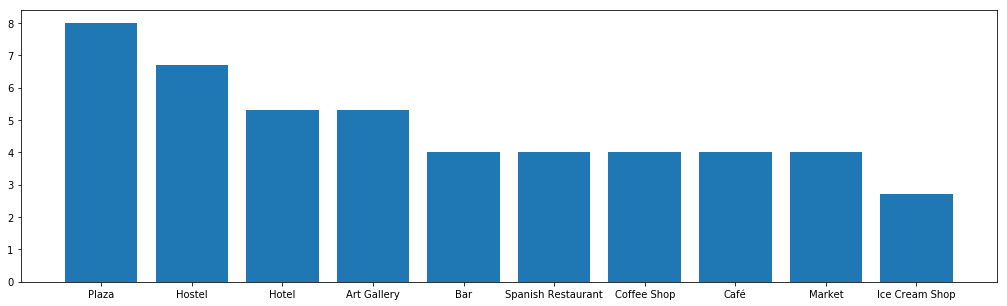





*************************************************** CLUSTER 1 ***************************************************

There are 125 neighborhoods labelled as Cluster 1 (96.9 %). 

There are 4826 venues in the neighborhoods labelled as Cluster 1. 

                    Count  Percentage
Spanish Restaurant    478         9.9
Restaurant            332         6.9
Bar                   209         4.3
Tapas Restaurant      173         3.6
Supermarket           136         2.8
Hotel                 135         2.8
Coffee Shop           125         2.6
Italian Restaurant    125         2.6
Café                  124         2.6
Bakery                124         2.6




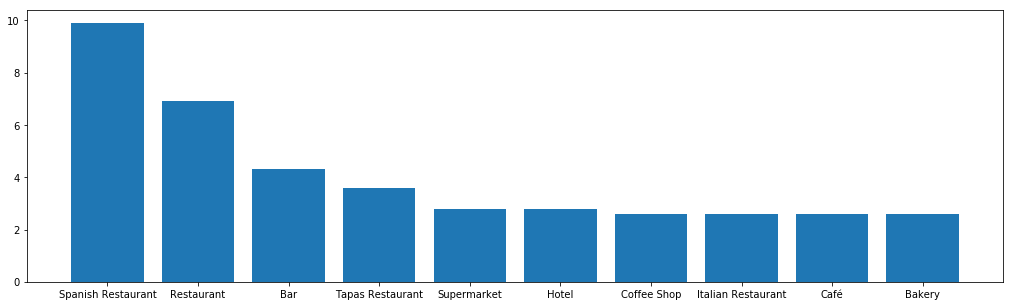





*************************************************** CLUSTER 2 ***************************************************

There are 1 neighborhoods labelled as Cluster 2 (0.8 %). 

There are 100 venues in the neighborhoods labelled as Cluster 2. 

                    Count  Percentage
Tapas Restaurant       18        18.0
Spanish Restaurant      9         9.0
Plaza                   7         7.0
Hotel                   6         6.0
Bar                     5         5.0
Church                  3         3.0
Historic Site           3         3.0
Cocktail Bar            3         3.0
Garden                  3         3.0
Park                    3         3.0




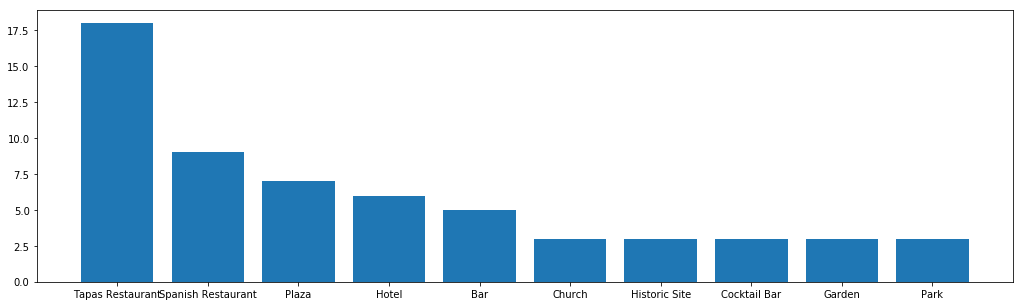





*************************************************** CLUSTER 3 ***************************************************

There are 1 neighborhoods labelled as Cluster 3 (0.8 %). 

There are 100 venues in the neighborhoods labelled as Cluster 3. 

                     Count  Percentage
Coffee Shop              5         5.0
Hotel                    5         5.0
Bookstore                5         5.0
Plaza                    5         5.0
Café                     5         5.0
Tapas Restaurant         4         4.0
Japanese Restaurant      3         3.0
Theater                  3         3.0
Restaurant               3         3.0
Bar                      3         3.0




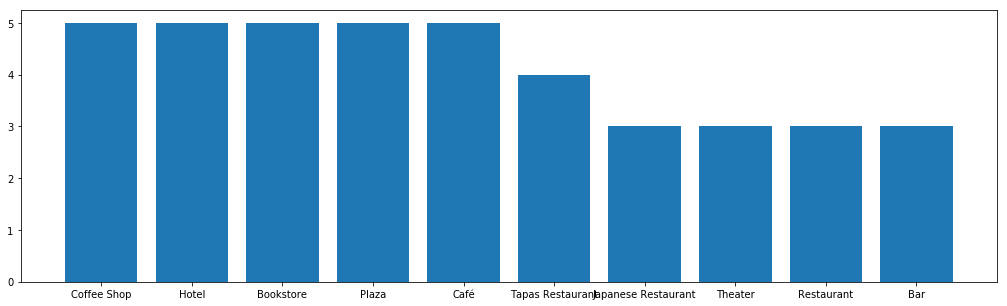





*************************************************** CLUSTER 4 ***************************************************

There are 1 neighborhoods labelled as Cluster 4 (0.8 %). 

There are 100 venues in the neighborhoods labelled as Cluster 4. 

                               Count  Percentage
Restaurant                         7         7.0
Spanish Restaurant                 6         6.0
Bakery                             6         6.0
Hotel                              6         6.0
Vegetarian / Vegan Restaurant      4         4.0
Deli / Bodega                      3         3.0
Cocktail Bar                       3         3.0
Italian Restaurant                 3         3.0
Bookstore                          3         3.0
Flower Shop                        3         3.0




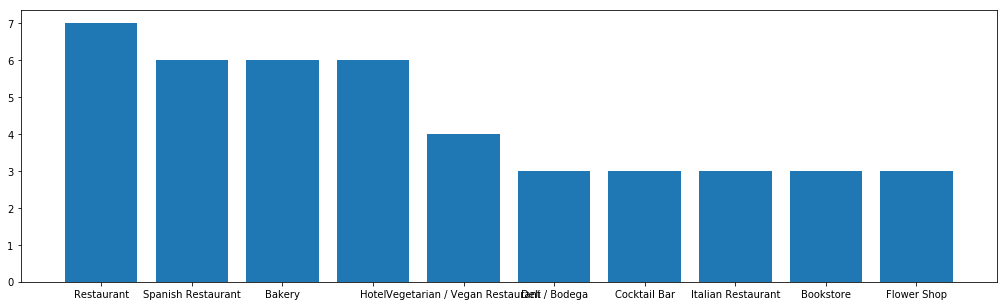

In [26]:
total_neighborhoods_count = len(madrid_neighborhoods.index)
for cluster in range(0, clusters_number):
    print("*************************************************** CLUSTER {} ***************************************************\n".format(cluster))
    
    neighborhoods_count = len(madrid_final_dataframe[madrid_final_dataframe["Cluster"] == cluster].index)
    print("There are {} neighborhoods labelled as Cluster {} ({} %). \n".format(neighborhoods_count, cluster, round(neighborhoods_count / total_neighborhoods_count * 100, 1)))
    
    neighborhoods_list = madrid_final_dataframe[madrid_final_dataframe["Cluster"] == cluster]["Neighborhood_"].values
    venues_in_labelled_neighborhoods = madrid_venues[madrid_venues["Neighborhood"].isin(neighborhoods_list)]["Venue category"]
    venues_in_labelled_neighborhoods_total_count = len(venues_in_labelled_neighborhoods.index)
    print("There are {} venues in the neighborhoods labelled as Cluster {}. \n".format(venues_in_labelled_neighborhoods_total_count, cluster))
    
    venues_in_labelled_neighborhoods_count = venues_in_labelled_neighborhoods.value_counts().to_frame(name = "Count")
    venues_in_labelled_neighborhoods_count["Percentage"] = venues_in_labelled_neighborhoods_count["Count"].apply(lambda x: round(x / venues_in_labelled_neighborhoods_total_count * 100, 1))
    print(venues_in_labelled_neighborhoods_count.head(10))
    print("\n")
    
    figure = matplotlib.pyplot.figure(figsize = (17.5,5))
    axes = figure.add_subplot(111)
    axes.bar(x = venues_in_labelled_neighborhoods_count.index[0:10], height = venues_in_labelled_neighborhoods_count["Percentage"].values[0:10])
    matplotlib.pyplot.show()
    
    print("\n\n\n")

---
**This clustering produced very uneven clusters: 96.9% of the neighborhoods belong to only 1 cluster, while the remaining 3.1% of the neighborhoods are distributed among the rest of the clusters. As a result, the map is almost coloured in only one colour, what makes it impossible to find any pattern in the distribution or extract any further information. <ins>This is attributed to the fact that restaurants seem to be ubiquitous in Madrid</ins>. Thus, in the second approach, this process is repeated after extricating the restaurants from the venues dataframe.**

---
---
---
### 4.2. Second approach

#### Data filtering

A copy of the original Madrid venues dataframe is made in order to filter the copy preserving the original one.

In [27]:
madrid_venues_R2 = madrid_venues
madrid_venues_R2.head()

,Neighborhood,Neighborhood latitude,Neighborhood longitude,Venue name,Venue category,Venue latitude,Venue longitude
0,Acacias,40.401068,-3.707261,La Gelateria di Angelo,Ice Cream Shop,40.397951,-3.707739
1,Acacias,40.401068,-3.707261,Parque de la Arganzuela,Park,40.398330,-3.708686
2,Acacias,40.401068,-3.707261,Restaurante Peruano Mis Tradiciones,Peruvian Restaurant,40.399816,-3.711022
3,Acacias,40.401068,-3.707261,sushi raku,Sushi Restaurant,40.404623,-3.708216
4,Acacias,40.401068,-3.707261,Le Crust Pizza Bar,Pizza Place,40.400922,-3.709890


---
The copy of the original Madrid venues dataframe is filtered to extricate the restaurants from it (as well as pizza places and bars).

In [28]:
madrid_venues_R2_filtered = madrid_venues_R2[madrid_venues_R2["Venue category"].str.contains("Restaurant") == False]
madrid_venues_R2_filtered = madrid_venues_R2_filtered[madrid_venues_R2_filtered["Venue category"].str.contains("Pizza Place") == False]
madrid_venues_R2_filtered = madrid_venues_R2_filtered[madrid_venues_R2_filtered["Venue category"].str.contains("Bar") == False]
madrid_venues_R2_filtered.reset_index(drop = True, inplace = True)

print("\nThere are {} venues left in the dataframe ({} venues were removed).\n".format(len(madrid_venues_R2_filtered.index), len(madrid_venues.index) - len(madrid_venues_R2_filtered.index)))


There are 2970 venues left in the dataframe (2231 venues were removed).



---
Unique categories are checked.

In [29]:
print("\nThere are {} unique categories ({} categories were removed).\n".format(len(madrid_venues_R2_filtered["Venue category"].unique()),len(madrid_venues["Venue category"].unique()) - len(madrid_venues_R2_filtered["Venue category"].unique())))


There are 246 unique categories (66 categories were removed).



---
---
#### Data pre processing


Venues categories are one-hot encoded.

In [30]:
madrid_venues_onehot_R2 = pandas.get_dummies(madrid_venues_R2_filtered[["Venue category"]], prefix = "", prefix_sep = "")
madrid_venues_onehot_R2.insert(loc = 0, column = "Neighborhood_", value = madrid_venues_R2_filtered["Neighborhood"]) # "_" is added after neighborhood since there is a "Neighborhood" column already
madrid_venues_onehot_R2.head()

,Neighborhood_,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Aquarium,Arcade,Art Gallery,Art Museum,...,Train Station,Travel Agency,Travel Lounge,Used Bookstore,Video Game Store,Warehouse Store,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Acacias,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acacias,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Acacias,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Acacias,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Acacias,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
print("\nOne-hot encoded madrid venues dataframe (R2): {} rows by {} columns.\n".format(madrid_venues_onehot_R2.shape[0], madrid_venues_onehot_R2.shape[1]))


One-hot encoded madrid venues dataframe (R2): 2970 rows by 247 columns.



---
The rows in one-hot encoded madrid venues dataframe are grouped by neighborhood. The sum() function is applied.

In [32]:
madrid_venues_neighborhood_R2 = madrid_venues_onehot_R2.groupby("Neighborhood_").sum().reset_index()
madrid_venues_neighborhood_R2.head()

,Neighborhood_,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Aquarium,Arcade,Art Gallery,Art Museum,...,Train Station,Travel Agency,Travel Lounge,Used Bookstore,Video Game Store,Warehouse Store,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Abrantes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acacias,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Adelfas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aeropuerto,2,0,1,8,5,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,Alameda de Osuna,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [33]:
print("\nMadrid venues grouped by neighborhood dataframe: {} rows by {} columns.\n".format(madrid_venues_neighborhood_R2.shape[0], madrid_venues_neighborhood_R2.shape[1]))


Madrid venues grouped by neighborhood dataframe: 129 rows by 247 columns.



---
The top venues categories by neighborhood are loaded into a pandas dataframe.

In [34]:
venues_categories_number = 10

# Columns are created according to venues_categories_number
columns = ["Neighborhood"]

for index in numpy.arange(venues_categories_number):
    columns.append("Top {} venues category".format(index + 1))

# Pandas dataframe is dreated
madrid_venues_neighborhood_sorted_R2 = pandas.DataFrame(columns = columns)
madrid_venues_neighborhood_sorted_R2["Neighborhood"] = madrid_venues_neighborhood_R2["Neighborhood_"]

for index in numpy.arange(madrid_venues_neighborhood_R2.shape[0]):
    madrid_venues_neighborhood_sorted_R2.iloc[index, 1:] = get_top_venues_categories(madrid_venues_neighborhood_R2.iloc[index, :], venues_categories_number)

madrid_venues_neighborhood_sorted_R2.head()

,Neighborhood,Top 1 venues category,Top 2 venues category,Top 3 venues category,Top 4 venues category,Top 5 venues category,Top 6 venues category,Top 7 venues category,Top 8 venues category,Top 9 venues category,Top 10 venues category
0,Abrantes,Park,Bakery,Athletics & Sports,Gym / Fitness Center,Embassy / Consulate,Donut Shop,Drive-in Theater,Duty-free Shop,Electronics Store,Zoo
1,Acacias,Supermarket,Park,Café,Playground,Indie Theater,Gym / Fitness Center,Plaza,Pub,Gym,Train Station
2,Adelfas,Supermarket,Coffee Shop,Diner,Grocery Store,Tea Room,Soccer Field,Gym,Sandwich Place,Hotel,Museum
3,Aeropuerto,Hotel,Coffee Shop,Airport Lounge,Duty-free Shop,Airport Service,Rental Car Location,Accessories Store,Breakfast Spot,Deli / Bodega,Grocery Store
4,Alameda de Osuna,Hotel,Gym,Garden,Tennis Court,Scenic Lookout,Bistro,Bakery,Metro Station,Coffee Shop,Park


---
---
#### K-Means

K-Means clustering algorithm is run against the final dataframe (i. e., one-hot encoded Madrid venues categories grouped by neighborhood) to cluster Madrid neighborhoods into 5 clusters.

In [35]:
clusters_number_R2 = 5

# The neighborhood column is dropped
madrid_venues_neighborhood_clustering_R2 = madrid_venues_neighborhood_R2.drop("Neighborhood_", axis = 1) 

# The dataframe is normalized so that features with different magnitudes and distributions are interpreted equally
#madrid_venues_neighborhood_clustering_R2 = StandardScaler().fit_transform(madrid_venues_neighborhood_clustering_R2)

# K-Means algorithm is run
kmeans_R2 = KMeans(n_clusters = clusters_number_R2, random_state = 0).fit(madrid_venues_neighborhood_clustering_R2)

# Cluster labels are checked
kmeans_R2.labels_[0:10] 

array([0, 0, 0, 4, 0, 2, 0, 0, 0, 0], dtype=int32)

---
---
#### Data post processing

The clusters are added back to the dataframe.

In [36]:
madrid_venues_neighborhood_sorted_R2.insert(0, "Cluster", kmeans_R2.labels_)
madrid_venues_neighborhood_sorted_R2.head()

,Cluster,Neighborhood,Top 1 venues category,Top 2 venues category,Top 3 venues category,Top 4 venues category,Top 5 venues category,Top 6 venues category,Top 7 venues category,Top 8 venues category,Top 9 venues category,Top 10 venues category
0,0,Abrantes,Park,Bakery,Athletics & Sports,Gym / Fitness Center,Embassy / Consulate,Donut Shop,Drive-in Theater,Duty-free Shop,Electronics Store,Zoo
1,0,Acacias,Supermarket,Park,Café,Playground,Indie Theater,Gym / Fitness Center,Plaza,Pub,Gym,Train Station
2,0,Adelfas,Supermarket,Coffee Shop,Diner,Grocery Store,Tea Room,Soccer Field,Gym,Sandwich Place,Hotel,Museum
3,4,Aeropuerto,Hotel,Coffee Shop,Airport Lounge,Duty-free Shop,Airport Service,Rental Car Location,Accessories Store,Breakfast Spot,Deli / Bodega,Grocery Store
4,0,Alameda de Osuna,Hotel,Gym,Garden,Tennis Court,Scenic Lookout,Bistro,Bakery,Metro Station,Coffee Shop,Park


---
The dataframe is merged with Madrid neighborhoods dataframe.

In [37]:
madrid_neighborhoods = madrid_neighborhoods.rename(columns = {"Neighborhood_": "Neighborhood"}) # Fix
madrid_final_dataframe_R2 = pandas.merge(madrid_neighborhoods, madrid_venues_neighborhood_sorted_R2, on = "Neighborhood")
madrid_final_dataframe_R2.head()

,Borough,Neighborhood,Area,Perimeter,Radius,X (ETRS89),Y (ETRS89),Latitude,Longitude,Cluster,Top 1 venues category,Top 2 venues category,Top 3 venues category,Top 4 venues category,Top 5 venues category,Top 6 venues category,Top 7 venues category,Top 8 venues category,Top 9 venues category,Top 10 venues category
0,Arganzuela,Acacias,1.073438e+06,3950.326928,584,439982.853563,4.472513e+06,40.401068,-3.707261,0,Supermarket,Park,Café,Playground,Indie Theater,Gym / Fitness Center,Plaza,Pub,Gym,Train Station
1,Arganzuela,Atocha,7.356806e+05,4957.687404,483,442131.234603,4.472353e+06,40.399774,-3.681931,0,Breakfast Spot,Grocery Store,Platform,Café,Food Truck,Bakery,Coffee Shop,Athletics & Sports,Snack Place,Hotel
2,Arganzuela,Chopera,5.677870e+05,3203.408600,425,440672.253579,4.471809e+06,40.394769,-3.699072,0,Coffee Shop,Art Gallery,Burger Joint,Park,Beer Garden,Garden,Farmers Market,Music Venue,Café,BBQ Joint
3,Arganzuela,Delicias,1.054679e+06,4818.002750,579,441453.464123,4.472028e+06,40.396799,-3.689887,0,Bakery,Snack Place,Grocery Store,Coffee Shop,Plaza,Gastropub,Movie Theater,Farmers Market,Breakfast Spot,Flea Market
4,Arganzuela,Imperial,9.676786e+05,4557.937959,554,439045.619911,4.473090e+06,40.406190,-3.718360,0,Park,Gym / Fitness Center,Hotel,Grocery Store,Beer Garden,Big Box Store,Garden,Café,Coffee Shop,Spa


---
---
#### Final map

The final map is visualized.

In [38]:
madrid_map_clusters_R2 = folium.Map(location = [40.4165000, -3.7025600], zoom_start = 11)

# Color scheme for the clusters
x = numpy.arange(clusters_number_R2)
y = [i + x + (i * x) ** 2 for i in range(clusters_number_R2)]
colors_array = cm.rainbow(numpy.linspace(0, 1, len(y)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Markers to the map
markers_colors = []
for latitude, longitude, neighborhood, cluster in zip(madrid_final_dataframe_R2["Latitude"], madrid_final_dataframe_R2["Longitude"], madrid_final_dataframe_R2["Neighborhood"], madrid_final_dataframe_R2["Cluster"]):
    label = folium.Popup(neighborhood + " (Cluster " + str(cluster) + ")", parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 3,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.25
        ).add_to(madrid_map_clusters_R2)
       
madrid_map_clusters_R2

---
---
#### Clusters inspection

*************************************************** CLUSTER 0 ***************************************************

There are 100 neighborhoods labelled as Cluster 0 (77.5 %). 

There are 1601 venues in the neighborhoods labelled as Cluster 0. 

                Count  Percentage
Park               97         6.1
Supermarket        92         5.7
Grocery Store      81         5.1
Hotel              64         4.0
Bakery             58         3.6
Coffee Shop        56         3.5
Gym                52         3.2
Café               49         3.1
Clothing Store     44         2.7
Plaza              41         2.6




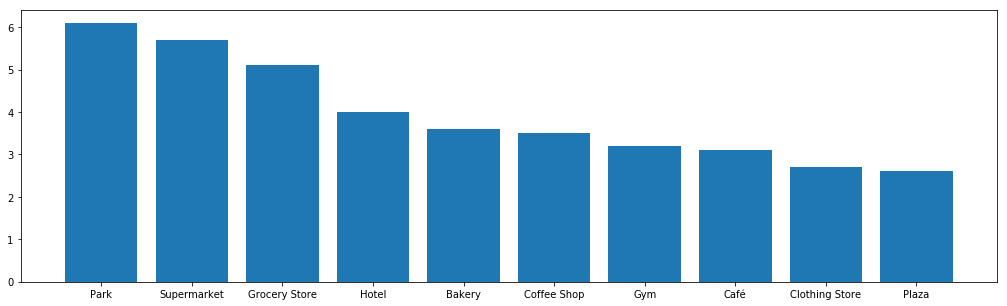





*************************************************** CLUSTER 1 ***************************************************

There are 5 neighborhoods labelled as Cluster 1 (3.9 %). 

There are 274 venues in the neighborhoods labelled as Cluster 1. 

                Count  Percentage
Hotel              28        10.2
Plaza              26         9.5
Café               16         5.8
Bookstore          10         3.6
Theater             9         3.3
Garden              9         3.3
Park                9         3.3
Coffee Shop         8         2.9
Hostel              7         2.6
Ice Cream Shop      6         2.2




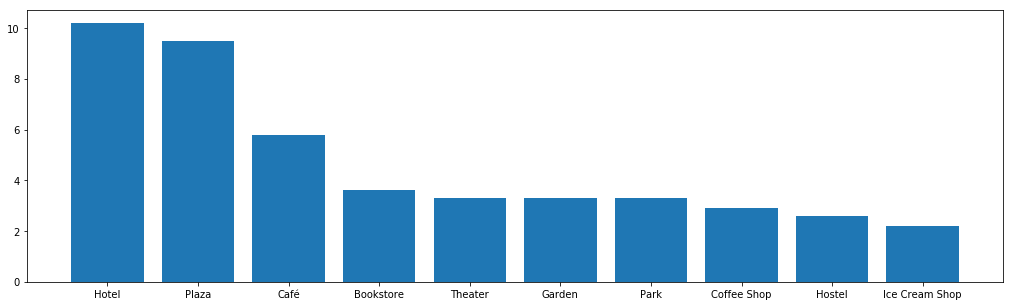





*************************************************** CLUSTER 2 ***************************************************

There are 22 neighborhoods labelled as Cluster 2 (17.1 %). 

There are 976 venues in the neighborhoods labelled as Cluster 2. 

                Count  Percentage
Bakery             69         7.1
Café               69         7.1
Coffee Shop        60         6.1
Hotel              54         5.5
Supermarket        42         4.3
Burger Joint       34         3.5
Plaza              31         3.2
Sandwich Place     30         3.1
Grocery Store      29         3.0
Brewery            21         2.2




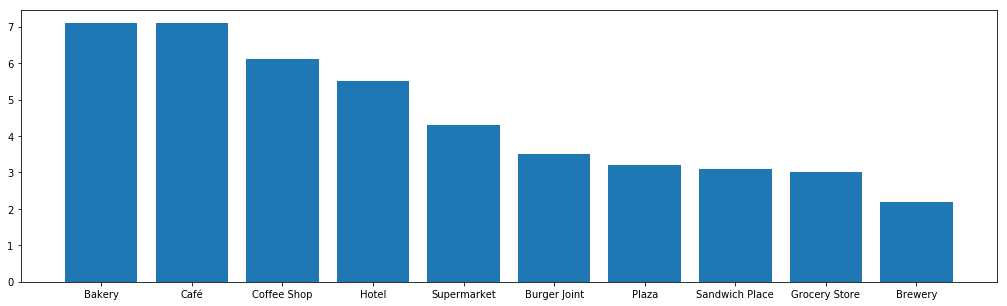





*************************************************** CLUSTER 3 ***************************************************

There are 1 neighborhoods labelled as Cluster 3 (0.8 %). 

There are 53 venues in the neighborhoods labelled as Cluster 3. 

                              Count  Percentage
Theme Park Ride / Attraction     13        24.5
Exhibit                           4         7.5
Grocery Store                     4         7.5
Park                              4         7.5
Pool                              3         5.7
Supermarket                       2         3.8
Student Center                    1         1.9
Theme Park                        1         1.9
Nightclub                         1         1.9
Metro Station                     1         1.9




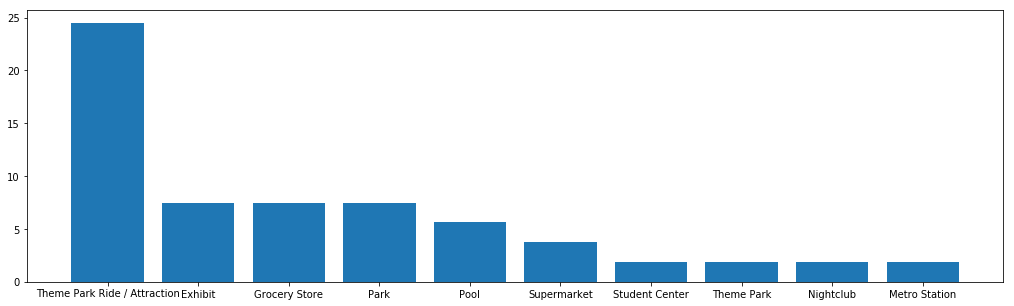





*************************************************** CLUSTER 4 ***************************************************

There are 1 neighborhoods labelled as Cluster 4 (0.8 %). 

There are 66 venues in the neighborhoods labelled as Cluster 4. 

                     Count  Percentage
Hotel                   10        15.2
Coffee Shop              9        13.6
Airport Lounge           8        12.1
Airport Service          5         7.6
Duty-free Shop           5         7.6
Rental Car Location      3         4.5
Accessories Store        2         3.0
Grocery Store            2         3.0
Breakfast Spot           2         3.0
Deli / Bodega            2         3.0




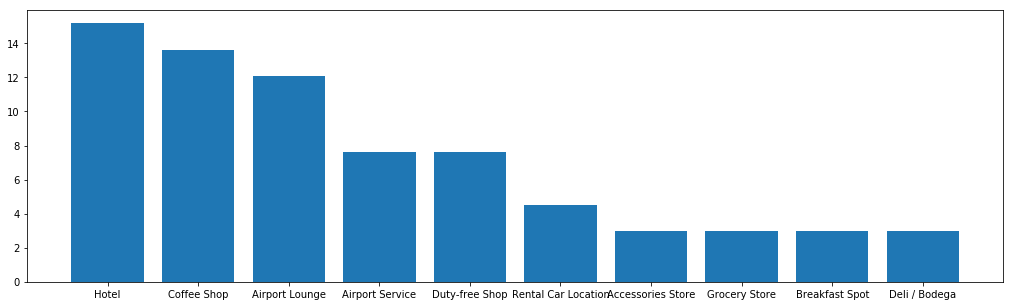

In [39]:
total_neighborhoods_count = len(madrid_neighborhoods.index)
for cluster in range(0, clusters_number_R2):
    print("*************************************************** CLUSTER {} ***************************************************\n".format(cluster))
    
    neighborhoods_count = len(madrid_final_dataframe_R2[madrid_final_dataframe_R2["Cluster"] == cluster].index)
    print("There are {} neighborhoods labelled as Cluster {} ({} %). \n".format(neighborhoods_count, cluster, round(neighborhoods_count / total_neighborhoods_count * 100, 1)))
    
    neighborhoods_list = madrid_final_dataframe_R2[madrid_final_dataframe_R2["Cluster"] == cluster]["Neighborhood"].values
    venues_in_labelled_neighborhoods = madrid_venues_R2_filtered[madrid_venues_R2_filtered["Neighborhood"].isin(neighborhoods_list)]["Venue category"]
    venues_in_labelled_neighborhoods_total_count = len(venues_in_labelled_neighborhoods.index)
    print("There are {} venues in the neighborhoods labelled as Cluster {}. \n".format(venues_in_labelled_neighborhoods_total_count, cluster))
    
    venues_in_labelled_neighborhoods_count = venues_in_labelled_neighborhoods.value_counts().to_frame(name = "Count")
    venues_in_labelled_neighborhoods_count["Percentage"] = venues_in_labelled_neighborhoods_count["Count"].apply(lambda x: round(x / venues_in_labelled_neighborhoods_total_count * 100, 1))
    print(venues_in_labelled_neighborhoods_count.head(10))
    print("\n")
    
    figure = matplotlib.pyplot.figure(figsize = (17.5,5))
    axes = figure.add_subplot(111)
    axes.bar(x = venues_in_labelled_neighborhoods_count.index[0:10], height = venues_in_labelled_neighborhoods_count["Percentage"].values[0:10])
    matplotlib.pyplot.show()
    
    print("\n\n\n")

---
---
---
## 5. Results

**Cluster 3 clearly corresponds to neighborhoods where the main venues categories are theme park rides and attractions**. There is only 1 neighborhood (0.8 %) labelled as Cluster 3: **Casa de Campo**. It can be thought of as a special neighborhood, since it borders Casa de Campo, the largest public park in Madrid, which houses **Madrid Amusement Park as well as Madrid Zoo**.

In [40]:
madrid_venues_R2[madrid_venues_R2["Neighborhood"] == "Casa de Campo"].reset_index(drop = True)

,Neighborhood,Neighborhood latitude,Neighborhood longitude,Venue name,Venue category,Venue latitude,Venue longitude
0,Casa de Campo,40.423633,-3.753051,Casa de Campo,Park,40.422383,-3.740673
1,Casa de Campo,40.423633,-3.753051,Tarántula,Theme Park Ride / Attraction,40.413076,-3.748920
2,Casa de Campo,40.423633,-3.753051,Parque de Atracciones de Madrid,Theme Park,40.411111,-3.749642
3,Casa de Campo,40.423633,-3.753051,TNT - Tren de la Mina,Theme Park Ride / Attraction,40.410750,-3.752173
4,Casa de Campo,40.423633,-3.753051,Territorio Panda,Exhibit,40.409920,-3.762383
5,Casa de Campo,40.423633,-3.753051,Espectaculo Leones Marinos,Exhibit,40.410513,-3.761922
6,Casa de Campo,40.423633,-3.753051,El Tornado,Theme Park Ride / Attraction,40.413522,-3.748758
7,Casa de Campo,40.423633,-3.753051,La Lanzadera,Theme Park Ride / Attraction,40.412681,-3.749651
8,Casa de Campo,40.423633,-3.753051,Zoo Aquarium de Madrid,Zoo,40.409482,-3.761443
9,Casa de Campo,40.423633,-3.753051,Vértigo,Theme Park Ride / Attraction,40.411718,-3.751124


---
**Cluster 2 seems to correspond to neighborhoods where the main venues categories are cafés and coffee shops, bakeries and hotels.** There are 22 neighborhoods (17.1 %) labelled as Cluster 2. The final map shows that these neighborhoods can be mostly found in boroughs such as Arganzüela, Chamartín, Chamberí, Retiro, Salamanca and Tetuán. These boroughs make up the **"Central Almond" of Madrid** (i. e., inside M30 Motorway), and can be thought of as **the downtown**. Only 2 neighborhoods which are not part of "Central Almond" are labelled as Cluster 2: Valverde (Fuencarral - El Pardo) and Simancas (San Blas - Canillejas).

In [41]:
madrid_final_dataframe_R2[madrid_final_dataframe_R2["Cluster"] == 2].reset_index(drop = True)

,Borough,Neighborhood,Area,Perimeter,Radius,X (ETRS89),Y (ETRS89),Latitude,Longitude,Cluster,Top 1 venues category,Top 2 venues category,Top 3 venues category,Top 4 venues category,Top 5 venues category,Top 6 venues category,Top 7 venues category,Top 8 venues category,Top 9 venues category,Top 10 venues category
0,Arganzuela,Palos de Moguer,6.484426e+05,3647.746587,454,441057.644465,4.472774e+06,40.403494,-3.694620,2,Bakery,Grocery Store,Gym / Fitness Center,Hotel,Coffee Shop,Café,Sandwich Place,Breakfast Spot,Beer Garden,Snack Place
1,Centro,Justicia,7.394140e+05,3597.421116,485,440900.762289,4.475014e+06,40.423661,-3.696677,2,Bakery,Hotel,Deli / Bodega,Flower Shop,Bookstore,Nightclub,Café,Cosmetics Shop,Sandwich Place,Beer Store
2,Chamartín,Castilla,2.161264e+06,6783.480759,829,442382.275125,4.480626e+06,40.474316,-3.679723,2,Café,Hotel,Coffee Shop,Gym / Fitness Center,Platform,Sandwich Place,Breakfast Spot,Bowling Alley,Building,Motorcycle Shop
3,Chamartín,Ciudad Jardín,7.623093e+05,3915.016305,492,442929.785109,4.477733e+06,40.448297,-3.673004,2,Café,Bakery,Supermarket,Coffee Shop,Concert Hall,Comedy Club,Music Venue,Bus Stop,Spa,Diner
4,Chamartín,El Viso,1.709233e+06,5270.830696,737,441927.295689,4.477361e+06,40.444874,-3.684791,2,Plaza,Coffee Shop,Grocery Store,Nightclub,Café,Science Museum,Supermarket,Bistro,Spa,Food
5,Chamartín,Hispanoamérica,1.712523e+06,6079.004961,738,442584.733925,4.478521e+06,40.455367,-3.677144,2,Bakery,Plaza,Gastropub,Grocery Store,Nightclub,Supermarket,Café,Diner,Coffee Shop,Pub
6,Chamartín,Prosperidad,1.040058e+06,5253.172983,575,443241.516309,4.477280e+06,40.444233,-3.669288,2,Café,Bakery,Coffee Shop,Supermarket,Gym,Pub,Diner,Hotel,Park,Burger Joint
7,Chamberí,Almagro,9.379404e+05,4073.714067,546,441174.995302,4.476032e+06,40.432850,-3.693539,2,Plaza,Hotel,Market,Bookstore,Bakery,Brewery,Food Stand,Spa,Bistro,Food Court
8,Chamberí,Arapiles,5.782297e+05,3096.149873,429,439947.558449,4.476215e+06,40.434407,-3.708026,2,Bakery,Café,Burrito Place,Sandwich Place,Supermarket,Theater,Toy / Game Store,Market,Neighborhood,Beer Store
9,Chamberí,Gaztambide,5.064779e+05,2969.109072,401,439389.894454,4.476283e+06,40.434985,-3.714607,2,Café,Sandwich Place,Pub,Coffee Shop,Beer Garden,Diner,Theater,Ice Cream Shop,Gastropub,Burger Joint


---
**Cluster 0 seems to correspond to neighborhoods where the main venues categories are parks, groceries stores and supermarkets**. There are 100 neighborhoods (77.5 %) labelled as Cluster 0. The final map shows that these neighborhoods can be mostly found in boroughs which are **outside the "Central Almond" of Madrid** (i. e., outside M30 Motorway). They can be thought of as **the suburbs (residential areas in the urban periphery)**. However, some of these neighborhoods are part of the "Central Almond" (though they are close to its limits): La Paz, Fuente del Berro, Legazpi, Ciudad Universitaria, etc.

In [42]:
madrid_final_dataframe_R2[madrid_final_dataframe_R2["Cluster"] == 0].reset_index(drop = True)

,Borough,Neighborhood,Area,Perimeter,Radius,X (ETRS89),Y (ETRS89),Latitude,Longitude,Cluster,Top 1 venues category,Top 2 venues category,Top 3 venues category,Top 4 venues category,Top 5 venues category,Top 6 venues category,Top 7 venues category,Top 8 venues category,Top 9 venues category,Top 10 venues category
0,Arganzuela,Acacias,1.073438e+06,3950.326928,584,439982.853563,4.472513e+06,40.401068,-3.707261,0,Supermarket,Park,Café,Playground,Indie Theater,Gym / Fitness Center,Plaza,Pub,Gym,Train Station
1,Arganzuela,Atocha,7.356806e+05,4957.687404,483,442131.234603,4.472353e+06,40.399774,-3.681931,0,Breakfast Spot,Grocery Store,Platform,Café,Food Truck,Bakery,Coffee Shop,Athletics & Sports,Snack Place,Hotel
2,Arganzuela,Chopera,5.677870e+05,3203.408600,425,440672.253579,4.471809e+06,40.394769,-3.699072,0,Coffee Shop,Art Gallery,Burger Joint,Park,Beer Garden,Garden,Farmers Market,Music Venue,Café,BBQ Joint
3,Arganzuela,Delicias,1.054679e+06,4818.002750,579,441453.464123,4.472028e+06,40.396799,-3.689887,0,Bakery,Snack Place,Grocery Store,Coffee Shop,Plaza,Gastropub,Movie Theater,Farmers Market,Breakfast Spot,Flea Market
4,Arganzuela,Imperial,9.676786e+05,4557.937959,554,439045.619911,4.473090e+06,40.406190,-3.718360,0,Park,Gym / Fitness Center,Hotel,Grocery Store,Beer Garden,Big Box Store,Garden,Café,Coffee Shop,Spa
5,Arganzuela,Legazpi,1.414471e+06,5141.640900,670,441682.939594,4.471151e+06,40.388919,-3.687103,0,Supermarket,Café,Dessert Shop,Park,Planetarium,Coffee Shop,Multiplex,Metro Station,Bistro,Theme Park
6,Barajas,Alameda de Osuna,1.970335e+06,6044.940349,791,449852.673085,4.478600e+06,40.456552,-3.591439,0,Hotel,Gym,Garden,Tennis Court,Scenic Lookout,Bistro,Bakery,Metro Station,Coffee Shop,Park
7,Barajas,Casco histórico de Barajas,5.493940e+05,3388.646288,418,450931.367518,4.480530e+06,40.474005,-3.578866,0,Hotel,Breakfast Spot,Café,Gastropub,Metro Station,Bistro,Coffee Shop,Boarding House,Sandwich Place,Grocery Store
8,Barajas,Corralejos,4.682538e+06,9726.951047,1220,448524.150151,4.479459e+06,40.464212,-3.607176,0,Park,Hotel,Convention Center,Art Gallery,Campground,Golf Course,Office,Public Art,Arcade,Pharmacy
9,Barajas,Timón,5.094466e+06,11840.044339,1273,448908.394536,4.480939e+06,40.477568,-3.602763,0,Soccer Field,Supermarket,Soccer Stadium,Golf Course,Train Station,Farm,Fabric Shop,Exhibit,Farmers Market,Dog Run


---
**Cluster 1 seems to correspond to neighborhoods where the main venues categories are hotels and plazas**. There are 5 neighborhoods (3.9 %) labelled as Cluster 1. The final map shows that these neighborhoods can be mostly found in Centro and Retiro boroughs (i. e., Madrid Old Town).

In [43]:
madrid_final_dataframe_R2[madrid_final_dataframe_R2["Cluster"] == 1].reset_index(drop = True)

,Borough,Neighborhood,Area,Perimeter,Radius,X (ETRS89),Y (ETRS89),Latitude,Longitude,Cluster,Top 1 venues category,Top 2 venues category,Top 3 venues category,Top 4 venues category,Top 5 venues category,Top 6 venues category,Top 7 venues category,Top 8 venues category,Top 9 venues category,Top 10 venues category
0,Centro,Cortes,5.918742e+05,3731.081180,434,440880.151887,4.474036e+06,40.414844,-3.696829,1,Hotel,Plaza,Café,Bookstore,Art Museum,Theater,Clothing Store,Casino,Food & Drink Shop,Breakfast Spot
1,Centro,Embajadores,1.033724e+06,4275.226882,573,440397.176558,4.473417e+06,40.409239,-3.702463,1,Plaza,Hostel,Art Gallery,Hotel,Coffee Shop,Café,Market,Theater,Ice Cream Shop,Bookstore
2,Centro,Palacio,1.469906e+06,5754.828224,684,439417.791353,4.474111e+06,40.415417,-3.714071,1,Plaza,Hotel,Church,Garden,Historic Site,Park,Snack Place,Music Venue,Theater,Ice Cream Shop
3,Centro,Universidad,9.480267e+05,4060.075479,549,440020.847601,4.475244e+06,40.425671,-3.707071,1,Hotel,Bookstore,Plaza,Coffee Shop,Café,Theater,Diner,Breakfast Spot,Miscellaneous Shop,Bakery
4,Retiro,Jerónimos,1.906398e+06,5287.485065,778,441870.669794,4.473906e+06,40.413744,-3.685143,1,Garden,Hotel,Park,Café,Monument / Landmark,Art Museum,Exhibit,Gastropub,Plaza,Museum


---
**Cluster 4 clearly corresponds to neighborhoods where the main venues categories are somehow linked to airports: hotels, coffee shops, airport lounges, airport services, duty free shops, etc.**. There is only 1 neighborhood (0.8 %) labelled as Cluster 4: **Aeropuerto**. It can also be thought of as a special neighborhood, since **it includes the territory around Aeropuerto Adolfo Suárez Madrid-Barajas, the main airport of Madrid**.

In [44]:
madrid_venues_R2[madrid_venues_R2["Neighborhood"] == "Aeropuerto"].reset_index(drop = True)

,Neighborhood,Neighborhood latitude,Neighborhood longitude,Venue name,Venue category,Venue latitude,Venue longitude
0,Aeropuerto,40.478555,-3.563443,La General,Bistro,40.470646,-3.580571
1,Aeropuerto,40.478555,-3.563443,InterRent Aeropuerto de Madrid Barajas - Adolf...,Rental Car Location,40.463446,-3.570471
2,Aeropuerto,40.478555,-3.563443,Taberna La Caprichosa,Spanish Restaurant,40.473318,-3.577521
3,Aeropuerto,40.478555,-3.563443,Finca Lucero,Argentinian Restaurant,40.470693,-3.583052
4,Aeropuerto,40.478555,-3.563443,Iberia Business Class Lounge,Airport Lounge,40.494629,-3.566370
5,Aeropuerto,40.478555,-3.563443,Sala VIP Iberia Velázquez,Airport Lounge,40.494599,-3.566403
6,Aeropuerto,40.478555,-3.563443,Aeropuerto Adolfo Suárez Madrid-Barajas (MAD) ...,Airport,40.481654,-3.578024
7,Aeropuerto,40.478555,-3.563443,Kirei by Kabuki,Japanese Restaurant,40.490557,-3.591285
8,Aeropuerto,40.478555,-3.563443,Hotel Ibis Madrid Aeropuerto Barajas,Hotel,40.469835,-3.580748
9,Aeropuerto,40.478555,-3.563443,Control de seguridad - puertas A a F,Airport Service,40.464389,-3.569789


---
---
---
## 6. Conclusion

The purpose of this project is **to reveal the distribution of venues among the neighborhoods in Madrid**. I. e., to find out where are the neighborhoods in which a certain venue category is specially usual, which is the most common venue category in each neighborhood?, whether it is there any "outlier" neighborhood in Madrid regarding its venues, and so on. In this case, **the stakeholders are entrepreneurs and investors from the fields of culture, leisure, catering and hostelry**. They could potentially benefit from the results of this project in when it comes to make choices such as: where in Madrid they should put into operation a business of a specific type (the old city, the down town, the suburbs); what business types are more and less common in the area of Madrid which they have targeted; are there any "outlier" neighborhoods in Madrid when it comes to venues and can they offer special market opportunities?

To do so, the following data have been used: **Madrid boroughs and neighborhoods data** (downloaded from Madrid Open Data website) and **venues data** (extracted from Foursquare). **These data have been pre processed to build a final dataframe** which shows how many venues of each category are in each neighborhood in Madrid.  

Then, **K-Means clustering algorithm has been run against the aforementioned dataframe in order to cluster the neighborhoods in Madrid** in a several clusters. These clusters have been inspected to find out their distinctive features. **Finally, they have been represented in a map with different colours depending on their cluster labels, which allows to visually identify their distribution in Madrid**, find out patterns in the distribution, "outlier" neighborhoods in Madrid, the areas of Madrid where it is common to find a specific business category, the most common business categories in a particular area of Madrid, and so on.

The first conclusion to be drawn from the project is that **restaurants (specially Spanish ones) seem to be ubiquitous in Madrid**. This led to a very uneven clustering that produced a very large cluster (it covered nearly 97% of the neighborhoods in Madrid) which characterized by a high preponderance of Spanish restaurants. So, the first idea for the stakeholders could be that, if they are planning to start a Spanish restaurant, it does not really matter where to do it, since they seem to work out everywhere in Madrid (or that Madrid is saturated with them).

In order to get more detailed results, **a second approach was adopted, but all restaurants were extricated from the dataframe this time**. Then, the previous process was repeated, and the following findings were made:
* **In the old town of Madrid (i. e., the neighborhoods in Centro borough) the top venues categories are clearly hotels and plazas**. This is the oldest area in the city and therefore it is full of historical buildings, monuments, cultural highlights and so on. Note that these neighborhoods account for only 3.9% of all neighborhoods count.
* **In the down town of Madrid (i. e., all boroughs inside the "Central Almond", such as Arganzüela, Chamartín, Chamberí, Retiro, Salamanca and Tetuán), the top venues categories are coffee shops and cafés, bakeries and hotels**. Though the population is slowly decreasing in this area, here is concentrated most of the economic activity. Note that these neighborhoods account for 17.1% of all neighborhoods count. Also note that there are 2 neighborhoods which are not part of "Central Almond" but have the same label: Valverde (Fuencarral - El Pardo) and Simancas (San Blas - Canillejas).
* **In the suburbs of Madrid (i. e., all boroughs outside the "Central Almond", such as Barajas, Carabanchel, Ciudad Lineal, Hortaleza and so on), the top venues categories are parks, supermarkets and groceries**. These are residential areas in the urban periphery. They are some times "bedroom communities", i. e., their inhabitants work in other areas of the city, and come back home only to rest. Note that these neighborhoods account for 77.5% of all neighborhoods count. Also note that some of these neighborhoods are part of the "Central Almond" (though they are close to its limits): La Paz, Fuente del Berro, Legazpi, Ciudad Universitaria, etc.
* **Casa de Campo is one "outlier" neighborhood**, since it is the only neighborhood in its cluster. **It is very clearly characterized by the presence of theme park rides, attraction and exhibits**. This neighborhood  borders Casa de Campo, the largest public park in Madrid, which houses Madrid Amusement Park as well as Madrid Zoo. Note that this neighborhood accounts for 0.8% of all neighborhoods count.
* **Aeropuerto is another "outlier" neighborhood**; it is also the only neighborhood in its cluster. **It is very clearly characterized by the presence of venues linked to airports: hotels, coffee shops, airport lounges, airport services, duty-free shop and so on**. This neighborhood includes the territory around Aeropuerto Adolfo Suárez Madrid-Barajas, the main airport of Madrid. Note that this neighborhood accounts for 0.8% of all neighborhoods count.